In [1]:
import pandas as pd 
import re
from scipy.stats import binom 
import statsmodels.stats.multitest as multi

In [24]:
#--------------------------------------------------
#TODO 统计每个基因包含外显子的数目，以及外显子的累积长度 
#--------------------------------------------------
gffDataFrame=pd.read_csv(
    "/public/home/zpliu/work/Alternative_review/genomeData/Ghirsutum_genome_HAU_v1.1/Ghirsutum_gene_model.gtf",
    header=None,sep="\t",index_col=None
    )
#* 转录本ID
gffDataFrame[9]=gffDataFrame[8].str.split(";",expand=True)[0].apply(lambda x:re.findall(r'\"([^\"]*)\"',x)[0])    
outData=[]
for transcriptId,transcriptData in gffDataFrame.groupby([9]):
    if re.findall(r'\.1$',transcriptId):
        #* 基因ID的信息就是转录本ID去除\.1
        ExonData=transcriptData.loc[transcriptData[2]=='exon']
        ExonData_length=ExonData.apply(lambda x:x[4]-x[3]+1,axis=1).sum()
        outData.append(
            (transcriptId,ExonData.shape[0],ExonData_length)
        )
    else:
        continue
outData=pd.DataFrame(outData,columns=['transcriptID','exonCount','exonLength'])   
outData.to_csv("gene_exonCount_length.txt",header=True,index=False,sep="\t") 

In [35]:
#--------------------------------------------------
#TODO 提取同源基因对，分析其基因exon数目和长度是否存在显著差异
#--------------------------------------------------
HomoeologousGene = pd.read_csv(
    "/data/cotton/zhenpingliu/LZP_fiberFullPopulationRNAseq/04homologExpressionPattern/Homoeolog_geneId.txt",
    header=None, index_col=None, sep="\t") 
geneExonCount=pd.read_csv("./gene_exonCount_length.txt",header=0,index_col=None,sep="\t")
geneExonCount.index=geneExonCount['transcriptID'].apply(lambda x:x.strip(".1"))

In [60]:
#TODO 提取同源基因的数据
genePairData=[]
for At,Dt in HomoeologousGene.values:
     genePairData.append(
         (
             "{}-{}".format(At,Dt),
         geneExonCount.loc[At][1],
         geneExonCount.loc[Dt][1],
         geneExonCount.loc[At][2],
         geneExonCount.loc[Dt][2])
     )
genePairData=pd.DataFrame(genePairData,columns=['genePair','AtExonCount','DtExonCount','AtLength','DtLength'])  
genePairData['ExonNumberDifference']=genePairData.apply(lambda x:abs(x['AtExonCount']-x['DtExonCount']),axis=1)
genePairData['ExonLengthDifference']=genePairData.apply(lambda x:abs(x['AtLength']-x['DtLength']),axis=1)
   
genePairData.to_csv("Homoeologous_ExonData.txt",header=True,index=False,sep="\t")

In [49]:
genePairData=pd.read_csv("./Homoeologous_ExonData.txt",header=0,index_col=None,sep="\t")

In [56]:
genePairData

,genePair,AtExonCount,DtExonCount,AtLength,DtLength,ExonNumberDifference,ExonLengthDifference
0,Ghir_A01G000040-Ghir_D01G000060,2,2,2416,2850,0,434
1,Ghir_A01G000070-Ghir_D01G000110,7,7,2978,2857,0,121
2,Ghir_A01G000080-Ghir_D01G000100,1,1,1445,1453,0,8
3,Ghir_A01G000100-Ghir_D01G000120,10,10,1239,1266,0,27
4,Ghir_A01G000110-Ghir_D01G000130,2,2,744,738,0,6
...,...,...,...,...,...,...,...
24033,Ghir_A13G025110-Ghir_D13G010850,15,14,3340,3276,1,64
24034,Ghir_A13G025130-Ghir_D13G012120,2,2,1850,1812,0,38
24035,Ghir_A13G025140-Ghir_D13G012140,3,3,1131,1507,0,376
24036,Ghir_A13G025160-Ghir_D13G006150,2,2,481,570,0,89


In [55]:
genePairData.loc[genePairData['ExonLengthDifference']>200]

,genePair,AtExonCount,DtExonCount,AtLength,DtLength,ExonNumberDifference,ExonLengthDifference
0,Ghir_A01G000040-Ghir_D01G000060,2,2,2416,2850,0,434
5,Ghir_A01G000130-Ghir_D01G000150,5,6,1115,462,1,653
8,Ghir_A01G000180-Ghir_D01G000190,7,8,1276,1944,1,668
12,Ghir_A01G000250-Ghir_D01G000260,2,2,712,1067,0,355
16,Ghir_A01G000290-Ghir_D01G000300,12,12,1960,2168,0,208
...,...,...,...,...,...,...,...
24026,Ghir_A13G025010-Ghir_D13G013290,2,2,3860,2322,0,1538
24028,Ghir_A13G025060-Ghir_D13G009180,5,5,945,1162,0,217
24032,Ghir_A13G025100-Ghir_D13G010860,6,6,993,3605,0,2612
24035,Ghir_A13G025140-Ghir_D13G012140,3,3,1131,1507,0,376


In [52]:
genePairData.loc[genePairData['ExonNumberDifference']>1]

,genePair,AtExonCount,DtExonCount,AtLength,DtLength,ExonNumberDifference,ExonLengthDifference
6,Ghir_A01G000160-Ghir_D01G000170,1,3,882,762,2,120
33,Ghir_A01G000600-Ghir_D01G000580,6,4,1308,1071,2,237
37,Ghir_A01G000690-Ghir_D01G000670,10,8,1122,1828,2,706
58,Ghir_A01G001050-Ghir_D01G001010,9,6,1455,2018,3,563
59,Ghir_A01G001060-Ghir_D01G001020,3,1,822,573,2,249
...,...,...,...,...,...,...,...
23976,Ghir_A13G024380-Ghir_D13G025110,2,5,1676,990,3,686
23978,Ghir_A13G024410-Ghir_D13G025160,14,11,3592,2957,3,635
23980,Ghir_A13G024430-Ghir_D13G025180,3,1,1290,1749,2,459
23983,Ghir_A13G024470-Ghir_D13G025250,3,1,2847,1605,2,1242


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from math import log2

/tmp/ipykernel_31649/1017957252.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(genePairData['ExonLengthDifference'].apply(lambda x:log2(x+1)), shade=True)


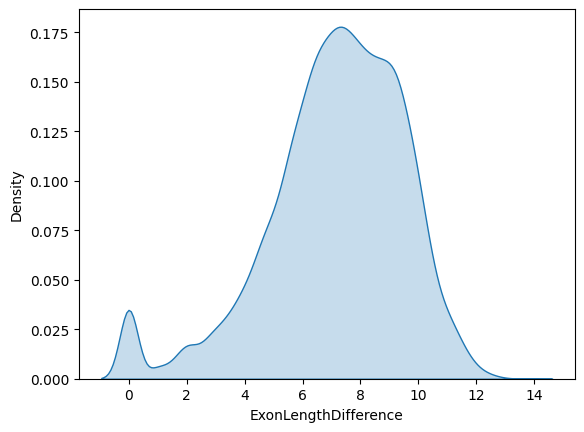

In [11]:
sns.kdeplot(genePairData['ExonLengthDifference'].apply(lambda x:log2(x+1)), shade=True)
plt.show()

In [14]:
genePairData.loc[genePairData['ExonNumberDifference']==0].shape,genePairData.shape

((17148, 7), (24038, 7))

In [16]:
genePairData.loc[genePairData['ExonLengthDifference']>=200].shape,genePairData.shape

((10786, 7), (24038, 7))

In [57]:
#TODO 合并所有基因在不同样本的数据
inputPath='/public/home/jhsun/zpliu/readCounts/0DPA/'

fileList=!ls /public/home/jhsun/zpliu/readCounts/0DPA
#* 所有的样本名
SampleList=[i.split("_htseq_readCout.tsv")[0] for i in fileList if re.findall(r'\.tsv$',i) ]

In [58]:
#* 合并数据
MergeData=pd.DataFrame()
for sample in SampleList:
    sampleData=pd.read_csv("{}/{}_htseq_readCout.tsv".format(inputPath,sample),header=None,index_col=0,sep="\t")
    #* 将read数目取整
    sampleData.columns=[sample]
    MergeData=pd.concat([MergeData,sampleData],axis=1)
geneList=[i for i in MergeData.index if re.match("^Ghir",i)]  
MergeData=MergeData.loc[geneList]  

In [59]:
MergeData.index.name='geneId'
MergeData.to_csv("0DPA/0DPA_geneRegion_readCount.txt",header=True,index=True,sep="\t")

In [4]:
#* 提取同源基因对的reads进行二项分布检验
HomoeologousGene = pd.read_csv(
    "/data/cotton/zhenpingliu/LZP_fiberFullPopulationRNAseq/04homologExpressionPattern/Homoeolog_geneId.txt",
    header=None, index_col=None, sep="\t") 
MergeData=pd.read_csv("12DPA_geneRegion_readCount.txt",header=0,index_col=0,sep="\t")     

In [19]:
# * 计算每个样本的二项分布检验pvalue和qvalue
# * 统计每个基因在所有样本中有多少是存在显著Bias的
geneBiasTypeStats = []
sampleBiasType=pd.DataFrame()
def Bias_Type(At,Dt,qval):
    #* 根据二项分布检验定义样本是否存在显著性的Bias
        if qval<=0.05 and At>=Dt:
            #* 显著BiasA
            return 1
        elif qval<=0.05 and At<Dt:
            return -1
        else:
            return 0
for At, Dt in HomoeologousGene.values:
    readCountData = MergeData.loc[[At, Dt]]
    readCountData = readCountData.T
    readCountData.columns = ['At', 'Dt']
    samplePval = []
    for Atread, Dtread in readCountData.values:
        if Atread+Dtread < 10:
            # * reads数目太少，无法进行有效的二项分布检验
            #! 相当于未表达的基因
            samplePval.append(1)
        else:
            samplePval.append(
                binom.pmf(Atread, Atread+Dtread, 0.5)
            )
    # * 对pvalue进行多重矫正
    sampleQvalue = multi.multipletests(samplePval)[1]
    
    readCountData['pval'] = samplePval
    readCountData['qval'] = sampleQvalue
    BiaDCount = readCountData.loc[(readCountData['qval'] <= 0.05) & (
        readCountData['At'] < readCountData['Dt'])].shape[0]
    BiaACount = readCountData.loc[(readCountData['qval'] <= 0.05) & (
        readCountData['At'] > readCountData['Dt'])].shape[0]
    BiasNCount = readCountData.loc[(readCountData['qval'] > 0.05)].shape[0]
    EzeroCount = readCountData.loc[readCountData['At'] +
                                   readCountData['Dt'] < 10].shape[0]
    # * 基于二项分布检验后，统计各种样本的占比
    geneBiasTypeStats.append(
        (
            "{}-{}".format(At, Dt), BiaACount, BiaDCount, BiasNCount, EzeroCount
        )
    )
    readCountData['{}-{}'.format(At,Dt)]=readCountData.apply(lambda x:Bias_Type(x['At'],x['Dt'],x['qval']),axis=1)
    sampleBiasType=pd.concat([sampleBiasType,readCountData[['{}-{}'.format(At,Dt)]]],axis=1)
    break

In [60]:
#-------------------------------------------------------
#TODO 基因在371份样本中的Bias数据 
#* 将批量跑的数据进行合并
#-------------------------------------------------------
import re 
fileList=!ls /public/home/jhsun/zpliu/readCounts/0DPA/splitData
sampleList=[i for i in fileList if re.findall('sample$',i)]
MergeData=pd.DataFrame()
for sampleName in sampleList:
    sampleData=pd.read_csv("{}{}".format(
        "/public/home/jhsun/zpliu/readCounts/0DPA/splitData/",sampleName),header=0,index_col=0,sep="\t"
    )
    MergeData=pd.concat([MergeData,sampleData],axis=1)
MergeData=MergeData.T   
MergeData.columns=[i.replace('Sample','S') for i in MergeData.columns]
MergeData.to_csv("0DPA/0DPA_BiasType_Sample_readCount.txt", 
                header=True,index=True,sep="\t") 

In [15]:
#--------------------------------------------------------------
#TODO 将FPKM计算得到的同源基因Bias模式进行编码
#--------------------------------------------------------------
BiasTypeMap={
    'Ezero':0,
    'BiasA':1,
    'BiasD':-1,
    'BiasN':0
}
HomoeologousBiasType=pd.read_csv(
    "/data/cotton/zhenpingliu/LZP_fiberFullPopulationRNAseq/04homologExpressionPattern/Homolog_ExpressionBias/0DPA_homoeolog_FPKM_type.txt",
    header=0,index_col=0,sep="\t")
#* 替换
HomoeologousBiasType=HomoeologousBiasType.applymap(lambda x:BiasTypeMap[x])
HomoeologousBiasType.to_csv("./0DPA_BiasType_Sample_FPKM.txt",header=True,index=True,sep="\t")

In [61]:
#--------------------------------------------------------------
#* 对于所有的同源基因对分析
#? FPKM 分析时有多少Bias基因对，read count分析时有多少同源基因对是Bias的
#! 在两种方法中都被定义相同方向Bias的基因对有多少
#--------------------------------------------------------------
FPKM_contribute=pd.read_csv(
    "/data/cotton/zhenpingliu/LZP_fiberFullPopulationRNAseq/04homologExpressionPattern/stage_Homoeolo_Bias/0DPA_homoeolog_Bias_contribution.txt",
    header=0,index_col=None,sep="\t"
    )
FPKM_contribute['BiasN']=FPKM_contribute[['BiasN','Ezero']].apply(lambda x:sum(x),axis=1)    
read_count_contribute=pd.read_csv("./0DPA/0DPA_homoeologouBiasContribution_readCount.txt",header=0,index_col=None,sep="\t")


In [62]:
#---------------------------------------------------------
#* 统计每个基因对在两种方法中各被定义为什么类型的Bias
#---------------------------------------------------------
def BiasType(x):
    At,Dt,BiasN=x
    if At/sum(x)>=0.05 and Dt/sum(x)<0.05:
        return 'BiasA'
    elif Dt/sum(x)>=0.05 and At/sum(x)<0.05:
        return 'BiasD'
    elif Dt/sum(x)<0.05 and At/sum(x)<0.05:
        return 'BiasN'
    else:
        return 'BidirectBias'
#* Bias基因类型
FPKM_contribute['BiasType']=FPKM_contribute[['BiasA','BiasD','BiasN']].apply(lambda x:BiasType(x),axis=1)
read_count_contribute['BiasType']=read_count_contribute[['BiasACount','BiasDCount','BiasNcount']].apply(lambda x:BiasType(x),axis=1)

In [63]:
read_count_contribute['BiasType'].value_counts()

BiasD           8480
BiasA           7710
BiasN           6487
BidirectBias    1361
Name: BiasType, dtype: int64

In [64]:
mergeBias=pd.concat(
    [
        FPKM_contribute[['BiasType']],
        read_count_contribute[['BiasType']]
    ],axis=1
)
mergeBias.columns=['FPKM','readCount']

In [65]:
mergeBias.loc[(mergeBias['FPKM']==mergeBias['readCount'])&(mergeBias['FPKM'].isin(['BiasA','BiasD']))]

,FPKM,readCount
5,BiasD,BiasD
8,BiasD,BiasD
14,BiasD,BiasD
19,BiasD,BiasD
23,BiasD,BiasD
...,...,...
24019,BiasA,BiasA
24022,BiasA,BiasA
24025,BiasD,BiasD
24032,BiasA,BiasA


In [31]:
#------------------------------------------------------------
#TODO: 提取时期间稳定Bias的基因对
#* 分析基因对在时期间相同bias的基因占比
#------------------------------------------------------------
MergeData=pd.DataFrame()
for stage in ['0DPA','4DPA','8DPA','12DPA','16DPA','20DPA']:
    FPKM_contribute=pd.read_csv(
    "/data/cotton/zhenpingliu/LZP_fiberFullPopulationRNAseq/04homologExpressionPattern/stage_Homoeolo_Bias/{}_homoeolog_Bias_contribution.txt".format(
        stage
    ),
    header=0,index_col=None,sep="\t"
    )
    FPKM_contribute=FPKM_contribute[['GeneID-GeneID','BiasType']]
    MergeData=pd.concat(
        [MergeData,FPKM_contribute],axis=1
    )
MergeData=MergeData.iloc[:,[0,1,3,5,7,9,11]]    
MergeData.columns=['genePair','0DPA','4DPA','8DPA','12DPA','16DPA','20DPA']
filterData=MergeData.loc[
    (MergeData['0DPA'] == MergeData['4DPA']) & (
        MergeData['4DPA'] == MergeData['8DPA']
    ) & (
        MergeData['8DPA'] == MergeData['12DPA']
    )&(
        MergeData['12DPA'] == MergeData['16DPA']
    )&(
        MergeData['16DPA'] == MergeData['20DPA']
    )&(
        MergeData['12DPA'].isin(['BiasA','BiasD'])
    )
]


In [35]:
#--------------------------------------------------------
#TODO 对这些基因对在不同时期间存在相同方向bias的样本占比
#--------------------------------------------------------
sample_BiasArray=[]
for stage in ['0DPA','4DPA','8DPA','12DPA','16DPA','20DPA']:
    sampleBias=pd.read_csv(
        "{}/{}_BiasType_Sample_FPKM.txt".format(
            stage,stage
        ),
        header=0,index_col=0,sep="\t"
    )
    sample_BiasArray.append(
        sampleBias
    )

In [99]:
#--------------------------------------------------------
#? 6个时期相同方向bias的基因对，有多少占比的样本是在6个时期稳定bias的
#--------------------------------------------------------
out=[]
for value in filterData.values:
    genePair,BiasType=value[0:2]
    biasCode=0
    if BiasType=='BiasD':
        biasCode=-1
    elif BiasType=='BiasA':
        biasCode=1
    StageSamplecount=[]
    AllstageSample=[]
    for stageData in sample_BiasArray:
        sampleList=[sample for sample,bias in stageData.loc[genePair].eq(biasCode).items() if bias==True]
        StageSamplecount.append(
            len(sampleList)
        )
        AllstageSample+=sampleList
    #* 6个时期都相同方向bias的样本
    commonlySampleCount=len([i for i in pd.Series(AllstageSample).value_counts() if i==6])
    out.append(
        (genePair,min(StageSamplecount),commonlySampleCount)
    )
out=pd.DataFrame(out,columns=['genePair','StageminBiasSample','commonlyBiasSample'])    

In [138]:
len([i for i in out.apply(
    lambda x:x['commonlyBiasSample']/x['StageminBiasSample'],
    axis=1).gt(0.8) if i==True])

983